In [43]:
## 0. Instalações

# wrapper que integra Keras (TensorFlow) com Scikit-Learn para facilitar o uso de GridSearchCV - pois antes o KerasRegressor nao esta funcionando (from keras.wrappers.scikit_learn import KerasRegressor)
# !pip install scikeras

# Acessar os valores das ações, petróleo (brent), ibovespa e minério de ferro
# !pip install yfinance

# Acessar a variável de entrada do fechamento do dólar
# !pip install python-bcb==0.3.3

# Foi preciso dar upgrade para rodar os imports
# !pip install --upgrade scikit-learn

In [44]:
## 1. Importação das Bibliotecas

# Leitura, interpretação e plotar os dados
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# Normalização e avaliação do modelo
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score

# Construção do modelo LSTM
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from keras.models import load_model
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import GridSearchCV

# Bases para as variáveis de entrada (features)
# import yfinance as yf
# from bcb import sgs

# Tempo de compilação, variáveis do sistema e aleatoriedade
import time
import os
import random

In [45]:
## 2. Criação de uma SEED

SEED = 0

def criar_seed(seed=SEED):
  os.environ['PYTHONHASHSEED'] = str(seed) # Controla aleatoriedade interna do interpretador Python
  random.seed(seed) # Controla aleatoriedade da biblioteca random
  np.random.seed(seed) # Controla aleatoriedade do NumPy
  tf.random.set_seed(seed) # Controla aleatoriedade do TensorFlow (pesos, embaralhamento, etc)

def setar_deterministico(seed=SEED): # Garantir que se obtenha os mesmos valores ao rodar o código novamente
  criar_seed(seed=seed) # Setar as seeds
  os.environ['TF_DETERMINISTIC_OPS'] = '1' # Força o TensorFlow a usar operações determinísticas
  os.environ['TF_CUDNN_DETERMINISTIC'] = '1' # Força operações determinísticas específicas da GPU (cuDNN)
  tf.config.threading.set_inter_op_parallelism_threads(1) # Limita o paralelismo entre operações a 1 thread
  tf.config.threading.set_intra_op_parallelism_threads(1) # Limita o paralelismo dentro de cada operação a 1 thread

setar_deterministico(SEED)  # Executa tudo acima com a seed escolhida

In [46]:
## 3. Coleta dos Dados

# Tempo inicial de compilação
_start_time = time.time()

# Datas de início e fim das features
start = '2012-08-01'
end = '2021-08-01'

# Dados da VALE3 (Close e Volume)
# vale = yf.download('VALE3.SA', start=start, end=end)[['Close', 'Volume']] # Filtra o período dos dados desejado e quais colunas deseja pegar da base de dados
# vale.columns = ['Close_VALE3', 'Volume_VALE3'] # Renomeia a coluna

# # Dólar
# dolar = sgs.get({'Close_Dolar': 1}, start=start, end=end).reset_index() # Faz com que Date deixe de ser index e passe a ser uma coluna junto ao Close_Dolar
# dolar['Date'] = pd.to_datetime(dolar['Date']) # Muda o type da coluna Date para Datetime para ficar igual as demais variáveis
# dolar.set_index('Date', inplace=True) # Retorna Date para index, pois é assim que as demais variáveis estão

# # Petróleo (WTI) pelo Yahoo Finance
# petroleo = yf.download('CL=F', start=start, end=end)[['Close']] # Preço do barril de petróleo WTI
# petroleo.columns = ['Close_Petroleo']

# # Ibovespa
# ibov = yf.download('^BVSP', start=start, end=end)[['Close']] # Índice ibovespa
# ibov.columns = ['Close_Ibovespa']

# # Minério de Ferro (supondo índice internacional)
# minerio = yf.download('RIO', start=start, end=end)[['Close']] # Ação da mineradora Rio Tinto
# minerio.columns = ['Close_Minerio']

In [47]:
## 4. Preparação e Merge dos Dados

# Unificar tudo em um DataFrame
# df = vale.copy() # Cria uma cópia do dataframe para ir dando o merge
# df = df.merge(dolar, left_index=True, right_index=True, how='left') # Junta os dados ao dataframe principal a partir do index (date)
# df = df.merge(petroleo, left_index=True, right_index=True, how='left')
# df = df.merge(ibov, left_index=True, right_index=True, how='left')
# df = df.merge(minerio, left_index=True, right_index=True, how='left')

# # Remover valores nulos
# df.dropna(inplace=True)

In [48]:
## 5. Normalização

# scaler = MinMaxScaler() # Usa o minmaxscaler como normalizador para escalar os dados entre 0 e 1
# dados_escalados = scaler.fit_transform(df) # Aplica o normalizador a todos os dados numéricos

In [49]:
## 6. Criação da Janela Deslizante (21 dias)
# scaler = joblib.load("../Dados/Treinamento/SBSP3/scaler_SBSP3.pkl")
# df = pd.read_csv("../Dados/Excel/Treinamento/df_completo_SBSP3.csv")

# df = df.drop(columns=["Date"])  # mantém só colunas numéricas iguais ao treino
# # Aplicar a transformação nos dados novos (df deve ser um DataFrame/array numérico)
# dados_escalados = scaler.transform(df.values)

# def createXY(dataset, n_past): # Função que cria as janelas deslizantes
#     dataX, dataY = [], []
#     for i in range(n_past, len(dataset)): # Começa no n_past (=21)
#         dataX.append(dataset[i - n_past:i, :]) # Para cada ponto no tempo, pega os últimos 'n_past' dias como entrada (X)
#         dataY.append(dataset[i, 0]) # A saída (y) será o valor de fechamento da VALE3 no dia seguinte; o índice 0 representa o Close_Vale3 que vai ser a variável de saída (predição)
#     return np.array(dataX), np.array(dataY)

# X, y = createXY(dados_escalados, 21) # Gera os arrays X (entradas) e y (saídas) com uma janela de 21 dias

# # Separar treino e teste (80/20)
# split = int(len(X) * 0.8) # Faz o corte de 80% dos dados
# X_train, X_test = X[:split], X[split:] # Train (treino) = 80% dos dados; test (teste) = 20% dos dados --> X
# y_train, y_test = y[:split], y[split:] # Train (treino) = 80% dos dados; test (teste) = 20% dos dados --> Y

In [ ]:
## 7. Construção do Modelo com GridSearchCV (2ª arquitetura)

X_train = np.load("../Dados/Treinamento/SBSP3/X_train_SBSP3.npy")
X_test = np.load("../Dados/Treinamento/SBSP3/X_test_SBSP3.npy")
y_test = np.load("../Dados/Treinamento/SBSP3/y_test_SBSP3.npy")
y_train = np.load("../Dados/Treinamento/SBSP3/y_train_SBSP3.npy")
scaler = joblib.load("../Dados/Treinamento/SBSP3/scaler_SBSP3.pkl")


def build_model(optimizer='adam'): # Função para criar o modelo LSTM como base para o GridSearchCV
    model = Sequential() # Cria um modelo sequencial (camadas empilhadas)
    model.add(LSTM(32, return_sequences=True, input_shape=(21, X_train.shape[2]))) # Primeira camada LSTM com 32 neurônios e retorno da sequência para a próxima LSTM
    model.add(LSTM(16)) # Segunda camada LSTM com 16 neurônios (sem return_sequences, pois é a última LSTM)
    model.add(Dense(10)) # Camada densa intermediária com 10 neurônios (pode ajudar a refinar a saída)
    model.add(Dense(1)) # Camada de saída com 1 neurônio (regressão: previsão de um único valor)
    model.compile(optimizer=optimizer, loss='mse') # Compila o modelo com o otimizador informado e função de erro MSE (erro quadrático médio)
    return model


model = KerasRegressor(model=build_model, verbose=1) # Envolve o modelo Keras dentro de um wrapper compatível com scikit-learn (necessário para o GridSearchCV)

params = { # Definição dos hiperparâmetros
    'batch_size': [5,10,16,36,144,288 ], # Tamanhos de lote a testar
    'epochs': [30,40,50], # Número de épocas de treino
    'optimizer': ['adam'] # Otimizador usado na compilação
}

grid = GridSearchCV(estimator=model, param_grid=params, cv=4) # Inicializa o GridSearchCV para encontrar os melhores hiperparâmetros usando validação cruzada (cv=4)
grid_result = grid.fit(X_train, y_train) # Realiza o treinamento e busca dos melhores parâmetros

Epoch 1/30


c:\Users\jv11g\Documents\TCC\.venv\Lib\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.1 when using version 1.7.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\jv11g\Documents\TCC\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


258/258 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0256
Epoch 2/30
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0014
Epoch 3/30
258/258 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0012
Epoch 4/30
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0011
Epoch 5/30
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 9.8815e-04
Epoch 6/30
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 9.0536e-04
Epoch 7/30
258/258 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 8.1983e-04
Epoch 8/30
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 7.3107e-04
Epoch 9/30
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 6.4581e-04
Epoch 10/30
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 5.7788e-04
Epoch 11/30
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 5.3226e-04
Epoch 12/30
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 5.0181e-04
Epoch 13/30
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 4.7986e-04
Epoch 14/30
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 4.6279e-04
Epoch 15/30
258/258 ━━━━━━━━

c:\Users\jv11g\Documents\TCC\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


258/258 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0149
Epoch 2/30
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0012
Epoch 3/30
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0011
Epoch 4/30
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0010
Epoch 5/30
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 9.2656e-04
Epoch 6/30
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 8.4190e-04
Epoch 7/30
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 7.5982e-04
Epoch 8/30
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 6.7824e-04
Epoch 9/30
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 6.0947e-04
Epoch 10/30
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 5.6539e-04
Epoch 11/30
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 5.3690e-04
Epoch 12/30
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 5.1452e-04
Epoch 13/30
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 4.9475e-04
Epoch 14/30
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 4.7638e-04
Epoch 15/30
258/258 ━━━━━━━━

c:\Users\jv11g\Documents\TCC\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


258/258 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0257
Epoch 2/30
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0012
Epoch 3/30
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0011
Epoch 4/30
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 9.6616e-04
Epoch 5/30
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 8.9351e-04
Epoch 6/30
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 8.3566e-04
Epoch 7/30
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 7.8920e-04
Epoch 8/30
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 7.4909e-04
Epoch 9/30
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 7.0985e-04
Epoch 10/30
258/258 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 6.6814e-04
Epoch 11/30
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 6.2371e-04
Epoch 12/30
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 5.7850e-04
Epoch 13/30
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 5.3643e-04
Epoch 14/30
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 5.0241e-04
Epoch 15/30
258/258 ━━━━

c:\Users\jv11g\Documents\TCC\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


258/258 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0056
Epoch 2/30
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 7.5243e-04
Epoch 3/30
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 6.4874e-04
Epoch 4/30
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 5.8295e-04
Epoch 5/30
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 5.3306e-04
Epoch 6/30
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 4.9457e-04
Epoch 7/30
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 4.6337e-04
Epoch 8/30
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 4.3665e-04
Epoch 9/30
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 4.1283e-04
Epoch 10/30
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 3.9096e-04
Epoch 11/30
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 3.7043e-04
Epoch 12/30
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 3.5095e-04
Epoch 13/30
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 3.3239e-04
Epoch 14/30
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 3.1455e-04
Epoch 15/30
258/

c:\Users\jv11g\Documents\TCC\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


258/258 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0161
Epoch 2/40
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0013
Epoch 3/40
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0012
Epoch 4/40
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0011
Epoch 5/40
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 9.8968e-04
Epoch 6/40
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 8.9478e-04
Epoch 7/40
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 8.1259e-04
Epoch 8/40
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 7.3727e-04
Epoch 9/40
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 6.6533e-04
Epoch 10/40
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 5.9746e-04
Epoch 11/40
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 5.3896e-04
Epoch 12/40
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 4.9558e-04
Epoch 13/40
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 4.6728e-04
Epoch 14/40
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 4.4902e-04
Epoch 15/40
258/258 ━━━━━━━━

c:\Users\jv11g\Documents\TCC\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


258/258 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0262
Epoch 2/40
258/258 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0016
Epoch 3/40
258/258 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0013
Epoch 4/40
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0012
Epoch 5/40
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0011
Epoch 6/40
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 9.9224e-04
Epoch 7/40
258/258 ━━━━━━━━━━━━━━━━━━━━ 625s 2s/step - loss: 9.2047e-04
Epoch 8/40
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 8.5704e-04
Epoch 9/40
258/258 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 7.9858e-04
Epoch 10/40
258/258 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 7.4312e-04
Epoch 11/40
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 6.8984e-04
Epoch 12/40
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 6.3905e-04
Epoch 13/40
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 5.9210e-04
Epoch 14/40
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 5.5110e-04
Epoch 15/40
258/258 ━━━━━━

c:\Users\jv11g\Documents\TCC\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


258/258 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0226
Epoch 2/40
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0012
Epoch 3/40
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0010 
Epoch 4/40
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 9.2472e-04
Epoch 5/40
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 8.6703e-04
Epoch 6/40
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 8.1926e-04
Epoch 7/40
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 7.7723e-04
Epoch 8/40
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 7.3745e-04
Epoch 9/40
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 6.9759e-04
Epoch 10/40
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 6.5665e-04
Epoch 11/40
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 6.1460e-04
Epoch 12/40
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 5.7230e-04
Epoch 13/40
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 5.3182e-04
Epoch 14/40
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 4.9631e-04
Epoch 15/40
258/258 ━━━

c:\Users\jv11g\Documents\TCC\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


258/258 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0156
Epoch 2/40
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 6.9939e-04
Epoch 3/40
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 6.1777e-04
Epoch 4/40
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 5.7116e-04
Epoch 5/40
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 5.3415e-04
Epoch 6/40
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 5.0109e-04
Epoch 7/40
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 4.7154e-04
Epoch 8/40
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 4.4531e-04
Epoch 9/40
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 4.2172e-04
Epoch 10/40
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 3.9993e-04
Epoch 11/40
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 3.7928e-04
Epoch 12/40
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 3.5947e-04
Epoch 13/40
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 3.4048e-04
Epoch 14/40
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 3.2246e-04
Epoch 15/40
258/

c:\Users\jv11g\Documents\TCC\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


258/258 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0424
Epoch 2/50
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0016
Epoch 3/50
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0013
Epoch 4/50
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0012
Epoch 5/50
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0011
Epoch 6/50
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 9.6595e-04
Epoch 7/50
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 8.9000e-04
Epoch 8/50
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 8.1944e-04
Epoch 9/50
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 7.5280e-04
Epoch 10/50
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 6.9136e-04
Epoch 11/50
258/258 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 6.3838e-04
Epoch 12/50
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 5.9643e-04
Epoch 13/50
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 5.6466e-04
Epoch 14/50
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 5.3993e-04
Epoch 15/50
258/258 ━━━━━━━━━━━━

c:\Users\jv11g\Documents\TCC\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


258/258 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0120
Epoch 2/50
258/258 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0013
Epoch 3/50
258/258 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0012
Epoch 4/50
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0010
Epoch 5/50
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 9.2753e-04
Epoch 6/50
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 8.3775e-04
Epoch 7/50
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 7.4931e-04
Epoch 8/50
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 6.6546e-04
Epoch 9/50
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 6.0226e-04
Epoch 10/50
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 5.6192e-04
Epoch 11/50
258/258 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 5.3169e-04
Epoch 12/50
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 5.0476e-04
Epoch 13/50
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 4.7961e-04
Epoch 14/50
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 4.5625e-04
Epoch 15/50
258/258 ━━━━━

c:\Users\jv11g\Documents\TCC\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


258/258 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0077
Epoch 2/50
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0013
Epoch 3/50
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0012
Epoch 4/50
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0011
Epoch 5/50
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0010
Epoch 6/50
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 8.9717e-04
Epoch 7/50
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 8.1765e-04
Epoch 8/50
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 7.5329e-04
Epoch 9/50
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 6.9279e-04
Epoch 10/50
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 6.3073e-04
Epoch 11/50
258/258 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 5.6628e-04
Epoch 12/50
258/258 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 5.0991e-04
Epoch 13/50
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 4.7659e-04
Epoch 14/50
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 4.5858e-04
Epoch 15/50
258/258 ━━━━━━━━━━━━

c:\Users\jv11g\Documents\TCC\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


258/258 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0124
Epoch 2/50
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 6.8166e-04
Epoch 3/50
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 6.5286e-04
Epoch 4/50
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 6.1132e-04
Epoch 5/50
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 5.7040e-04
Epoch 6/50
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 5.3435e-04
Epoch 7/50
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 5.0313e-04
Epoch 8/50
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 4.7583e-04
Epoch 9/50
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 4.5147e-04
Epoch 10/50
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 4.2913e-04
Epoch 11/50
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 4.0790e-04
Epoch 12/50
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 3.8693e-04
Epoch 13/50
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 3.6562e-04
Epoch 14/50
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 3.4413e-04
Epoch 15/50
258/

c:\Users\jv11g\Documents\TCC\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


129/129 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0209
Epoch 2/30
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0017
Epoch 3/30
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0013
Epoch 4/30
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0011
Epoch 5/30
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 9.9556e-04
Epoch 6/30
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 9.1847e-04
Epoch 7/30
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 8.6145e-04
Epoch 8/30
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 8.1743e-04
Epoch 9/30
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 7.8176e-04
Epoch 10/30
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 7.5110e-04
Epoch 11/30
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 7.2325e-04
Epoch 12/30
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 6.9700e-04
Epoch 13/30
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 6.7173e-04
Epoch 14/30
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 6.4718e-04
Epoch 15/30
129/129 ━━━━━━━━

c:\Users\jv11g\Documents\TCC\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


129/129 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0154
Epoch 2/30
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0014
Epoch 3/30
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0013
Epoch 4/30
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0012
Epoch 5/30
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0011
Epoch 6/30
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0010
Epoch 7/30
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 9.4723e-04
Epoch 8/30
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 8.8503e-04
Epoch 9/30
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 8.2710e-04
Epoch 10/30
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 7.7077e-04
Epoch 11/30
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 7.1440e-04
Epoch 12/30
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 6.5759e-04
Epoch 13/30
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 6.0140e-04
Epoch 14/30
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 5.4938e-04
Epoch 15/30
129/129 ━━━━━━━━━━━━━━━━

c:\Users\jv11g\Documents\TCC\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


129/129 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0252
Epoch 2/30
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0013
Epoch 3/30
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0011
Epoch 4/30
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0011
Epoch 5/30
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0010
Epoch 6/30
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 9.5193e-04
Epoch 7/30
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 9.0398e-04
Epoch 8/30
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 8.6043e-04
Epoch 9/30
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 8.2068e-04
Epoch 10/30
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 7.8416e-04
Epoch 11/30
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 7.5041e-04
Epoch 12/30
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 7.1906e-04
Epoch 13/30
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 6.8978e-04
Epoch 14/30
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 6.6231e-04
Epoch 15/30
129/129 ━━━━━━━━━━━━

c:\Users\jv11g\Documents\TCC\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


129/129 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.0066
Epoch 2/30
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 6.5563e-04
Epoch 3/30
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 5.4987e-04
Epoch 4/30
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 4.9934e-04
Epoch 5/30
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 4.5584e-04
Epoch 6/30
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 4.1865e-04
Epoch 7/30
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 3.8784e-04
Epoch 8/30
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 3.6279e-04
Epoch 9/30
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 3.4207e-04
Epoch 10/30
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 3.2449e-04
Epoch 11/30
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 3.0955e-04
Epoch 12/30
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.9709e-04
Epoch 13/30
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.8691e-04
Epoch 14/30
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.7846e-04
Epoch 15/30
129

c:\Users\jv11g\Documents\TCC\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


129/129 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0398
Epoch 2/40
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0022
Epoch 3/40
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0015
Epoch 4/40
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0013
Epoch 5/40
129/129 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0012
Epoch 6/40
129/129 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0011
Epoch 7/40
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0010
Epoch 8/40
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 9.5844e-04
Epoch 9/40
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 8.9674e-04
Epoch 10/40
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 8.4255e-04
Epoch 11/40
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 7.9335e-04
Epoch 12/40
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 7.4689e-04
Epoch 13/40
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 7.0144e-04
Epoch 14/40
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 6.5603e-04
Epoch 15/40
129/129 ━━━━━━━━━━━━━━━━━━

c:\Users\jv11g\Documents\TCC\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


129/129 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.0497
Epoch 2/40
129/129 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0015
Epoch 3/40
129/129 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0013
Epoch 4/40
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0012
Epoch 5/40
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0011
Epoch 6/40
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0010
Epoch 7/40
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 9.7692e-04
Epoch 8/40
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 9.2168e-04
Epoch 9/40
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 8.7267e-04
Epoch 10/40
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 8.3080e-04
Epoch 11/40
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.9507e-04
Epoch 12/40
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.6365e-04
Epoch 13/40
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.3492e-04
Epoch 14/40
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.0778e-04
Epoch 15/40
129/129 ━━━━━━━━━━━━━━

c:\Users\jv11g\Documents\TCC\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


129/129 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0377
Epoch 2/40
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0016
Epoch 3/40
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0014
Epoch 4/40
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0013
Epoch 5/40
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0012
Epoch 6/40
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0011
Epoch 7/40
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 9.7010e-04
Epoch 8/40
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 8.9451e-04
Epoch 9/40
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 8.2809e-04
Epoch 10/40
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 7.7068e-04
Epoch 11/40
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 7.2080e-04
Epoch 12/40
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 6.7591e-04
Epoch 13/40
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 6.3309e-04
Epoch 14/40
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 5.9000e-04
Epoch 15/40
129/129 ━━━━━━━━━━━━━━━━

c:\Users\jv11g\Documents\TCC\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


129/129 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0320
Epoch 2/40
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 6.5823e-04
Epoch 3/40
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 5.9177e-04
Epoch 4/40
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 5.5160e-04
Epoch 5/40
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 5.1870e-04
Epoch 6/40
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 4.9006e-04
Epoch 7/40
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 4.6521e-04
Epoch 8/40
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 4.4338e-04
Epoch 9/40
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 4.2421e-04
Epoch 10/40
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 4.0734e-04
Epoch 11/40
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3.9243e-04
Epoch 12/40
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3.7918e-04
Epoch 13/40
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3.6730e-04
Epoch 14/40
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3.5654e-04
Epoch 15/40
129/

c:\Users\jv11g\Documents\TCC\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


129/129 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0144
Epoch 2/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0014
Epoch 3/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0013
Epoch 4/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0011
Epoch 5/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0010 
Epoch 6/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 9.2199e-04
Epoch 7/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 8.4412e-04
Epoch 8/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 7.7841e-04
Epoch 9/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 7.1789e-04
Epoch 10/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 6.6075e-04
Epoch 11/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 6.0721e-04
Epoch 12/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 5.5834e-04
Epoch 13/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 5.1620e-04
Epoch 14/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 4.8303e-04
Epoch 15/50
129/129 ━━━━━━━━━━━

c:\Users\jv11g\Documents\TCC\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


129/129 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0173
Epoch 2/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0014
Epoch 3/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0012
Epoch 4/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0011
Epoch 5/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0011
Epoch 6/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0010
Epoch 7/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 9.5708e-04
Epoch 8/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 9.1278e-04
Epoch 9/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 8.7366e-04
Epoch 10/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 8.3787e-04
Epoch 11/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 8.0429e-04
Epoch 12/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 7.7218e-04
Epoch 13/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 7.4104e-04
Epoch 14/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 7.1048e-04
Epoch 15/50
129/129 ━━━━━━━━━━━━━━━━

c:\Users\jv11g\Documents\TCC\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


129/129 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0133
Epoch 2/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0015
Epoch 3/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0013
Epoch 4/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0012
Epoch 5/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0011
Epoch 6/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 9.9911e-04
Epoch 7/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 9.2527e-04
Epoch 8/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 8.6179e-04
Epoch 9/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 8.0629e-04
Epoch 10/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 7.5650e-04
Epoch 11/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 7.1028e-04
Epoch 12/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 6.6598e-04
Epoch 13/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 6.2257e-04
Epoch 14/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 5.7970e-04
Epoch 15/50
129/129 ━━━━━━━━━━━━

c:\Users\jv11g\Documents\TCC\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


129/129 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0117
Epoch 2/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 6.8920e-04
Epoch 3/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 6.3435e-04
Epoch 4/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 5.9223e-04
Epoch 5/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 5.5001e-04
Epoch 6/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 5.0918e-04
Epoch 7/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 4.7027e-04
Epoch 8/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 4.3394e-04
Epoch 9/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 4.0169e-04
Epoch 10/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 3.7542e-04
Epoch 11/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 3.5562e-04
Epoch 12/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 3.4066e-04
Epoch 13/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 3.2834e-04
Epoch 14/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3.1720e-04
Epoch 15/50
129/

c:\Users\jv11g\Documents\TCC\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0687
Epoch 2/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0020
Epoch 3/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0014
Epoch 4/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0013
Epoch 5/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0012
Epoch 6/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0011
Epoch 7/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0011
Epoch 8/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0010
Epoch 9/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 9.8617e-04
Epoch 10/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 9.4128e-04
Epoch 11/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 8.9971e-04
Epoch 12/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 8.6134e-04
Epoch 13/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 8.2597e-04
Epoch 14/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 7.9337e-04
Epoch 15/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 7.63

c:\Users\jv11g\Documents\TCC\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0495
Epoch 2/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0027
Epoch 3/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0016
Epoch 4/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0013
Epoch 5/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0012
Epoch 6/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0011
Epoch 7/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0011
Epoch 8/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0010
Epoch 9/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 9.6137e-04
Epoch 10/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 9.2194e-04
Epoch 11/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 8.8800e-04
Epoch 12/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 8.5808e-04
Epoch 13/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 8.3120e-04
Epoch 14/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 8.0669e-04
Epoch 15/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 7.8405e-04
Ep

c:\Users\jv11g\Documents\TCC\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0481
Epoch 2/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0023
Epoch 3/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0018
Epoch 4/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0017
Epoch 5/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0015
Epoch 6/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0014
Epoch 7/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0013
Epoch 8/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0012
Epoch 9/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0011
Epoch 10/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0010
Epoch 11/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 9.4082e-04
Epoch 12/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 8.8111e-04
Epoch 13/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 8.2753e-04
Epoch 14/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 7.7900e-04
Epoch 15/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 7.3511e-04
Epoch 16/3

c:\Users\jv11g\Documents\TCC\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0155
Epoch 2/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 7.1206e-04
Epoch 3/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 5.7713e-04
Epoch 4/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 5.2034e-04
Epoch 5/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 5.1233e-04
Epoch 6/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 5.0209e-04
Epoch 7/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 4.8408e-04
Epoch 8/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 4.6515e-04
Epoch 9/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 4.4680e-04
Epoch 10/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 4.2942e-04
Epoch 11/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 4.1305e-04
Epoch 12/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3.9764e-04
Epoch 13/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3.8312e-04
Epoch 14/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3.6946e-04
Epoch 15/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 6m

c:\Users\jv11g\Documents\TCC\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0325
Epoch 2/40
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0015
Epoch 3/40
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0012
Epoch 4/40
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0011
Epoch 5/40
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0011
Epoch 6/40
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0010
Epoch 7/40
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 9.6840e-04
Epoch 8/40
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 9.1610e-04
Epoch 9/40
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 8.6801e-04
Epoch 10/40
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 8.2449e-04
Epoch 11/40
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 7.8543e-04
Epoch 12/40
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 7.5051e-04
Epoch 13/40
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 7.1927e-04
Epoch 14/40
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 6.9121e-04
Epoch 15/40
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 6.658

c:\Users\jv11g\Documents\TCC\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0124
Epoch 2/40
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0018
Epoch 3/40
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0015
Epoch 4/40
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0013
Epoch 5/40
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0011
Epoch 6/40
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0011
Epoch 7/40
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 9.8388e-04
Epoch 8/40
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 9.2410e-04
Epoch 9/40
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 8.7366e-04
Epoch 10/40
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 8.3006e-04
Epoch 11/40
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 7.9161e-04
Epoch 12/40
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 7.5710e-04
Epoch 13/40
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 7.2568e-04
Epoch 14/40
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 6.9678e-04
Epoch 15/40
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 6.700

c:\Users\jv11g\Documents\TCC\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0241
Epoch 2/40
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0016
Epoch 3/40
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0013
Epoch 4/40
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0012
Epoch 5/40
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0011
Epoch 6/40
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0010
Epoch 7/40
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 9.9320e-04
Epoch 8/40
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 9.4415e-04
Epoch 9/40
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 9.0062e-04
Epoch 10/40
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 8.6157e-04
Epoch 11/40
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 8.2638e-04
Epoch 12/40
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 7.9441e-04
Epoch 13/40
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 7.6510e-04
Epoch 14/40
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 7.3798e-04
Epoch 15/40
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.126

c:\Users\jv11g\Documents\TCC\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0195
Epoch 2/40
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.9919e-04
Epoch 3/40
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 6.3505e-04
Epoch 4/40
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 5.6603e-04
Epoch 5/40
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 5.4052e-04
Epoch 6/40
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 5.2227e-04
Epoch 7/40
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 5.0477e-04
Epoch 8/40
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 4.8720e-04
Epoch 9/40
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 4.7012e-04
Epoch 10/40
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 4.5393e-04
Epoch 11/40
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 4.3877e-04
Epoch 12/40
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 4.2466e-04
Epoch 13/40
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 4.1152e-04
Epoch 14/40
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 3.9924e-04
Epoch 15/40
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 9m

c:\Users\jv11g\Documents\TCC\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0333
Epoch 2/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0020
Epoch 3/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0016
Epoch 4/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0014
Epoch 5/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0013
Epoch 6/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0012
Epoch 7/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0011
Epoch 8/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0011
Epoch 9/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 9.9819e-04
Epoch 10/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 9.4981e-04
Epoch 11/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 9.0685e-04
Epoch 12/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 8.6823e-04
Epoch 13/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 8.3309e-04
Epoch 14/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 8.0070e-04
Epoch 15/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 7.7052e-04
Ep

c:\Users\jv11g\Documents\TCC\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0371
Epoch 2/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0024
Epoch 3/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0017
Epoch 4/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0014
Epoch 5/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0013
Epoch 6/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0012
Epoch 7/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0011
Epoch 8/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0011
Epoch 9/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0010  
Epoch 10/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 9.6133e-04
Epoch 11/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 9.2030e-04
Epoch 12/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 8.8376e-04
Epoch 13/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 8.5095e-04
Epoch 14/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 8.2125e-04
Epoch 15/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.9412e-04
Epoc

c:\Users\jv11g\Documents\TCC\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0229
Epoch 2/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0015
Epoch 3/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0012
Epoch 4/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0012
Epoch 5/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0011
Epoch 6/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0010
Epoch 7/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 9.8171e-04
Epoch 8/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 9.3232e-04
Epoch 9/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 8.8685e-04
Epoch 10/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 8.4529e-04
Epoch 11/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 8.0756e-04
Epoch 12/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.7346e-04
Epoch 13/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.4262e-04
Epoch 14/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 7.1458e-04
Epoch 15/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 6.887

c:\Users\jv11g\Documents\TCC\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0144
Epoch 2/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0015
Epoch 3/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 6.8120e-04
Epoch 4/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 5.9617e-04
Epoch 5/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 5.5868e-04
Epoch 6/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 5.3494e-04
Epoch 7/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 5.1303e-04
Epoch 8/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 4.9157e-04
Epoch 9/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.7200e-04
Epoch 10/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 4.5456e-04
Epoch 11/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 4.3903e-04
Epoch 12/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 4.2510e-04
Epoch 13/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 4.1250e-04
Epoch 14/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 4.0097e-04
Epoch 15/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/

c:\Users\jv11g\Documents\TCC\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0530
Epoch 2/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0049
Epoch 3/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0032
Epoch 4/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0024
Epoch 5/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0021
Epoch 6/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0018
Epoch 7/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0015
Epoch 8/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0013
Epoch 9/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0012
Epoch 10/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0011
Epoch 11/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0010
Epoch 12/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 9.8122e-04
Epoch 13/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 9.4228e-04
Epoch 14/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 9.0912e-04
Epoch 15/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 8.8054e-04
Epoch 16/30

c:\Users\jv11g\Documents\TCC\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0965
Epoch 2/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0087
Epoch 3/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0035
Epoch 4/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0018
Epoch 5/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0017
Epoch 6/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0016
Epoch 7/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0015
Epoch 8/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0015
Epoch 9/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0014
Epoch 10/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0014
Epoch 11/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0013
Epoch 12/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0013
Epoch 13/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0012
Epoch 14/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0012
Epoch 15/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0011
Epoch 16/30
36/

c:\Users\jv11g\Documents\TCC\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.1039
Epoch 2/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0074
Epoch 3/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0025
Epoch 4/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0015
Epoch 5/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0012
Epoch 6/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0012
Epoch 7/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0011
Epoch 8/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0011
Epoch 9/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0010
Epoch 10/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0010    
Epoch 11/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 9.7382e-04
Epoch 12/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 9.4659e-04
Epoch 13/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 9.2061e-04
Epoch 14/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 8.9553e-04
Epoch 15/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 8.

c:\Users\jv11g\Documents\TCC\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0198
Epoch 2/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0019
Epoch 3/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0011
Epoch 4/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 9.0399e-04
Epoch 5/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 7.9706e-04
Epoch 6/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 7.0415e-04
Epoch 7/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 6.3041e-04
Epoch 8/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5.9249e-04
Epoch 9/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5.6851e-04
Epoch 10/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5.5064e-04
Epoch 11/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 5.3527e-04
Epoch 12/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 5.2068e-04
Epoch 13/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 5.0630e-04
Epoch 14/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 4.9201e-04
Epoch 15/30
36/36 ━━━━━━━━━━━━━━━━━━━━

c:\Users\jv11g\Documents\TCC\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0574
Epoch 2/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0027
Epoch 3/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0013
Epoch 4/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0012
Epoch 5/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0011
Epoch 6/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0011
Epoch 7/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0010
Epoch 8/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 9.7640e-04
Epoch 9/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 9.4456e-04
Epoch 10/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 9.1796e-04
Epoch 11/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 8.9609e-04
Epoch 12/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 8.7870e-04
Epoch 13/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 8.6443e-04
Epoch 14/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 8.5115e-04
Epoch 15/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - 

c:\Users\jv11g\Documents\TCC\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0797
Epoch 2/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0112
Epoch 3/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0038
Epoch 4/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0019
Epoch 5/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0018
Epoch 6/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0017
Epoch 7/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0016
Epoch 8/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0015
Epoch 9/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0014
Epoch 10/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0013
Epoch 11/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0012
Epoch 12/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0012
Epoch 13/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0011
Epoch 14/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0010
Epoch 15/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0010  
Epoch 16/40
36

c:\Users\jv11g\Documents\TCC\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0676
Epoch 2/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0056
Epoch 3/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0024
Epoch 4/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0016
Epoch 5/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0015
Epoch 6/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0014
Epoch 7/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0013  
Epoch 8/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0012 
Epoch 9/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0012 
Epoch 10/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0011 
Epoch 11/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0011 
Epoch 12/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0010  
Epoch 13/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0010   
Epoch 14/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 9.7716e-04
Epoch 15/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 9.4860e-04
Epoch

c:\Users\jv11g\Documents\TCC\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0125
Epoch 2/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 9.2371e-04
Epoch 3/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 6.2638e-04
Epoch 4/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.8437e-04
Epoch 5/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.7573e-04
Epoch 6/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.6371e-04
Epoch 7/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.4661e-04
Epoch 8/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.2957e-04
Epoch 9/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.1360e-04
Epoch 10/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.9856e-04
Epoch 11/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.8420e-04
Epoch 12/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.7033e-04
Epoch 13/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.5677e-04
Epoch 14/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.4338e-04
Epoch 15/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7m

c:\Users\jv11g\Documents\TCC\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0456
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0026
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0016
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0015
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0014
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0014
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0013 
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0012 
Epoch 9/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0012 
Epoch 10/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0011 
Epoch 11/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0011 
Epoch 12/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0010  
Epoch 13/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 9.9873e-04
Epoch 14/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 9.5890e-04
Epoch 15/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 9.2202e-04
Epoch 16/50

c:\Users\jv11g\Documents\TCC\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0195
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0025
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0017
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0014
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0013
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0011 
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 9.2172e-04
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 8.2277e-04
Epoch 9/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 7.7449e-04
Epoch 10/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 7.4873e-04
Epoch 11/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 7.3264e-04
Epoch 12/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 7.1955e-04
Epoch 13/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 7.0685e-04
Epoch 14/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 6.9437e-04
Epoch 15/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 6.82

c:\Users\jv11g\Documents\TCC\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0824
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0054
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0017
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0012 
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0011 
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0011 
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0011  
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0010  
Epoch 9/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0010    
Epoch 10/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 9.7496e-04
Epoch 11/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 9.4669e-04
Epoch 12/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 9.1662e-04
Epoch 13/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 8.8526e-04
Epoch 14/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 8.5300e-04
Epoch 15/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 8.2038

c:\Users\jv11g\Documents\TCC\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0197
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0013
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 7.5724e-04
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 6.6515e-04
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 6.1249e-04
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 6.0465e-04
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.9897e-04
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.9003e-04
Epoch 9/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.7559e-04
Epoch 10/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.5766e-04
Epoch 11/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.3813e-04
Epoch 12/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.1787e-04
Epoch 13/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.9718e-04
Epoch 14/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.7632e-04
Epoch 15/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/st

c:\Users\jv11g\Documents\TCC\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.1291
Epoch 2/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0313
Epoch 3/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0135
Epoch 4/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0092
Epoch 5/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0067
Epoch 6/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0048
Epoch 7/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0038
Epoch 8/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0031
Epoch 9/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0024
Epoch 10/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0018
Epoch 11/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0015
Epoch 12/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0014
Epoch 13/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0013
Epoch 14/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0013
Epoch 15/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0012
Epoch 16/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/

c:\Users\jv11g\Documents\TCC\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.1123
Epoch 2/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0285
Epoch 3/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0137
Epoch 4/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0121
Epoch 5/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0101
Epoch 6/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0084
Epoch 7/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0066
Epoch 8/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0054
Epoch 9/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0038
Epoch 10/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0027
Epoch 11/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0019
Epoch 12/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0015
Epoch 13/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0015
Epoch 14/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0015
Epoch 15/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0015
Epoch 16/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/stepWARNING:tensorflow:6 out of the last 18 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x0000018D33EC1440> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
Epoch 1/30


c:\Users\jv11g\Documents\TCC\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.1095
Epoch 2/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0267
Epoch 3/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0077
Epoch 4/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0054
Epoch 5/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0037
Epoch 6/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0027
Epoch 7/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0021
Epoch 8/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0017
Epoch 9/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0015
Epoch 10/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0014
Epoch 11/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0013
Epoch 12/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0013
Epoch 13/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0013
Epoch 14/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0012
Epoch 15/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0012
Epoch 16/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/

c:\Users\jv11g\Documents\TCC\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0082
Epoch 2/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0023
Epoch 3/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0013
Epoch 4/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 7.5663e-04
Epoch 5/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 7.5115e-04
Epoch 6/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 6.6425e-04
Epoch 7/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 6.1923e-04
Epoch 8/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 5.8153e-04
Epoch 9/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5.5458e-04
Epoch 10/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5.3795e-04
Epoch 11/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5.2200e-04
Epoch 12/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 5.0730e-04
Epoch 13/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 4.9528e-04
Epoch 14/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.8412e-04
Epoch 15/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 4.7577e-

c:\Users\jv11g\Documents\TCC\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0635
Epoch 2/40
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0235
Epoch 3/40
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0105
Epoch 4/40
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0056
Epoch 5/40
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0046
Epoch 6/40
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0034
Epoch 7/40
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0032
Epoch 8/40
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0026
Epoch 9/40
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0023
Epoch 10/40
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0020
Epoch 11/40
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0018
Epoch 12/40
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0016
Epoch 13/40
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0015
Epoch 14/40
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0015
Epoch 15/40
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0014
Epoch 16/40
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/

c:\Users\jv11g\Documents\TCC\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.1417
Epoch 2/40
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0391
Epoch 3/40
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0147
Epoch 4/40
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0078
Epoch 5/40
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0054
Epoch 6/40
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0034
Epoch 7/40
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0030
Epoch 8/40
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0023
Epoch 9/40
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0020
Epoch 10/40
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0017
Epoch 11/40
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0017
Epoch 12/40
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0016
Epoch 13/40
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0016
Epoch 14/40
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0016
Epoch 15/40
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0015
Epoch 16/40
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/

c:\Users\jv11g\Documents\TCC\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.2849
Epoch 2/40
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0398
Epoch 3/40
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0171
Epoch 4/40
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0110
Epoch 5/40
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0044
Epoch 6/40
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0034
Epoch 7/40
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0027
Epoch 8/40
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0024
Epoch 9/40
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0021
Epoch 10/40
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0019
Epoch 11/40
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0018
Epoch 12/40
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0017
Epoch 13/40
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0016
Epoch 14/40
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0016
Epoch 15/40
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0015
Epoch 16/40
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/

c:\Users\jv11g\Documents\TCC\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0835
Epoch 2/40
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0176
Epoch 3/40
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0110
Epoch 4/40
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0051
Epoch 5/40
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0038
Epoch 6/40
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0030
Epoch 7/40
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0019
Epoch 8/40
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0014
Epoch 9/40
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0010
Epoch 10/40
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 8.2464e-04
Epoch 11/40
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 6.6767e-04
Epoch 12/40
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 5.9467e-04
Epoch 13/40
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 5.5822e-04
Epoch 14/40
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 5.4500e-04
Epoch 15/40
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 5.3646e-04
Epoch 16/40
9/9 ━━━━━

c:\Users\jv11g\Documents\TCC\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0365
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0144
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0060
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0030
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0018
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0015
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0015
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0015
Epoch 9/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0015
Epoch 10/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0015
Epoch 11/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0014
Epoch 12/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0014
Epoch 13/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0014
Epoch 14/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0014
Epoch 15/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0014
Epoch 16/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/

c:\Users\jv11g\Documents\TCC\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.2223
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0282
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0233
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0162
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0115
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0107
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0082
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0063
Epoch 9/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0044
Epoch 10/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0030
Epoch 11/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0022
Epoch 12/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0018
Epoch 13/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0016
Epoch 14/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0016
Epoch 15/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0015
Epoch 16/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/

c:\Users\jv11g\Documents\TCC\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0641
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0134
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0054
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0040
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0029
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0021
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0017
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0014
Epoch 9/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0013
Epoch 10/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0013
Epoch 11/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0012
Epoch 12/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0012
Epoch 13/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0011
Epoch 14/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0011
Epoch 15/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0011
Epoch 16/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/

c:\Users\jv11g\Documents\TCC\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0474
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0107
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0082
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0041
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0023
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0014
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0012
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 9.4275e-04
Epoch 9/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 8.6048e-04
Epoch 10/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 8.1460e-04
Epoch 11/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 7.6468e-04
Epoch 12/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 7.3168e-04
Epoch 13/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 6.9954e-04
Epoch 14/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 6.6945e-04
Epoch 15/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 6.4488e-04
Epoch 16/50
9

c:\Users\jv11g\Documents\TCC\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.3171
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0522
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0637
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0239
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0222
Epoch 6/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0153
Epoch 7/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0087
Epoch 8/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0088
Epoch 9/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0049
Epoch 10/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0043
Epoch 11/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0033
Epoch 12/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0033
Epoch 13/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0030
Epoch 14/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0028
Epoch 15/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0026
Epoch 16/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/

c:\Users\jv11g\Documents\TCC\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.2762
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0494
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0168
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0300
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0141
Epoch 6/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0092
Epoch 7/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0109
Epoch 8/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0091
Epoch 9/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0070
Epoch 10/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0071
Epoch 11/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0065
Epoch 12/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0054
Epoch 13/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0049
Epoch 14/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0043
Epoch 15/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0038
Epoch 16/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/

c:\Users\jv11g\Documents\TCC\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0755
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0289
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0227
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0138
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0121
Epoch 6/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0082
Epoch 7/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0079
Epoch 8/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0057
Epoch 9/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0047
Epoch 10/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0044
Epoch 11/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0036
Epoch 12/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0030
Epoch 13/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0027
Epoch 14/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0023
Epoch 15/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0020
Epoch 16/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/

c:\Users\jv11g\Documents\TCC\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0225
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0113
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0085
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0049
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0027
Epoch 6/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0020
Epoch 7/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0018
Epoch 8/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0016
Epoch 9/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0013
Epoch 10/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0012
Epoch 11/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0011
Epoch 12/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 9.9925e-04
Epoch 13/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 9.1048e-04
Epoch 14/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 8.6855e-04
Epoch 15/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 8.0961e-04
Epoch 16/30
5/5 ━━━━━━━━━━━━━

c:\Users\jv11g\Documents\TCC\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0783
Epoch 2/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0315
Epoch 3/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0310
Epoch 4/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0197
Epoch 5/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0167
Epoch 6/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0116
Epoch 7/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0103
Epoch 8/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0074
Epoch 9/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0058
Epoch 10/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0050
Epoch 11/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0038
Epoch 12/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0033
Epoch 13/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0028
Epoch 14/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0025
Epoch 15/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0022
Epoch 16/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/

c:\Users\jv11g\Documents\TCC\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0521
Epoch 2/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0271
Epoch 3/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0122
Epoch 4/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0124
Epoch 5/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0080
Epoch 6/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0084
Epoch 7/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0058
Epoch 8/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0048
Epoch 9/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0034
Epoch 10/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0028
Epoch 11/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0022
Epoch 12/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0018
Epoch 13/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0016
Epoch 14/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0016
Epoch 15/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0015
Epoch 16/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/

c:\Users\jv11g\Documents\TCC\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.1621
Epoch 2/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0518
Epoch 3/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0326
Epoch 4/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0354
Epoch 5/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0235
Epoch 6/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0195
Epoch 7/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0162
Epoch 8/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0110
Epoch 9/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0086
Epoch 10/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0057
Epoch 11/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0039
Epoch 12/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0027
Epoch 13/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0024
Epoch 14/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0023
Epoch 15/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0021
Epoch 16/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/

c:\Users\jv11g\Documents\TCC\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0727
Epoch 2/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0227
Epoch 3/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0126
Epoch 4/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0146
Epoch 5/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0101
Epoch 6/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0088
Epoch 7/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0085
Epoch 8/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0067
Epoch 9/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0055
Epoch 10/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0045
Epoch 11/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0034
Epoch 12/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0027
Epoch 13/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0021
Epoch 14/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0017
Epoch 15/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0013
Epoch 16/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/

c:\Users\jv11g\Documents\TCC\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.1672
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0402
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0469
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0230
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0181
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0107
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0084
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0052
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0047
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0041
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0034
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0028
Epoch 13/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0025
Epoch 14/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0021
Epoch 15/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0018
Epoch 16/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/

c:\Users\jv11g\Documents\TCC\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.1173
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0172
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0265
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0072
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0093
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0067
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0048
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0055
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0038
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0036
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0030
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0029
Epoch 13/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0026
Epoch 14/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0023
Epoch 15/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0021
Epoch 16/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/

c:\Users\jv11g\Documents\TCC\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 0.1855
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0229
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0318
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0216
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0097
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0113
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0084
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0053
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0055
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0042
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0035
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0033
Epoch 13/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0029
Epoch 14/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0028
Epoch 15/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0025
Epoch 16/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/

c:\Users\jv11g\Documents\TCC\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.1444
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0238
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0280
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0120
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0093
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0098
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0070
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0062
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0055
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0044
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0040
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0033
Epoch 13/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0029
Epoch 14/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0025
Epoch 15/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0022
Epoch 16/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/

c:\Users\jv11g\Documents\TCC\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


172/172 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0241
Epoch 2/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0018
Epoch 3/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0014
Epoch 4/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0012
Epoch 5/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0010
Epoch 6/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 9.3114e-04
Epoch 7/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 8.3701e-04
Epoch 8/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 7.5632e-04
Epoch 9/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 6.8751e-04
Epoch 10/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 6.2874e-04
Epoch 11/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 5.7885e-04
Epoch 12/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 5.3723e-04
Epoch 13/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 5.0319e-04
Epoch 14/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 4.7541e-04
Epoch 15/50
172/172 ━━━━━━━━━━━━

In [51]:
## 8. Avaliação do Modelo

best_model = grid_result.best_estimator_ # Recupera o melhor modelo encontrado pelo GridSearchCV
# pred = best_model.predict(X_test) # Faz a predição dos valores do conjunto de teste

# # Expande as previsões para 6 colunas simuladas (como se fossem as 6 features)
# pred_expand = np.repeat(pred.reshape(-1, 1), df.shape[1], axis=1) # Expande a predição para ter o mesmo número de colunas que o DataFrame original (necessário para desfazer a normalização)
# y_expand = np.repeat(y_test.reshape(-1, 1), df.shape[1], axis=1) # Faz o mesmo com os valores reais (y_test), para poder comparar os dados reais com os previstos no mesmo formato

pred = best_model.predict(X_test).reshape(-1)  # (N,)

# Nº de features que o scaler viu ao treinar
n_features = getattr(scaler, "n_features_in_", None)
if n_features is None:
    # fallback seguro se você normalizou antes de criar janelas
    n_features = X_train.shape[2]

# Índice da coluna alvo no DF original normalizado (ajuste se não for 0)
target_idx = 0

# Monte matrizes com o mesmo nº de colunas do scaler e preencha só a target
pred_expand = np.zeros((pred.shape[0], n_features), dtype=float)
pred_expand[:, target_idx] = pred

y_expand = np.zeros((y_test.shape[0], n_features), dtype=float)
y_expand[:, target_idx] = y_test.reshape(-1)

# Inverte a normalização e pega só a primeira coluna (Close_VALE3)
pred_real = scaler.inverse_transform(pred_expand)[:, 0] # Inverte a normalização nas previsões e pega só a 1ª coluna (preço da VALE3)
y_real = scaler.inverse_transform(y_expand)[:, 0] # Inverte a normalização nos valores reais (y_test) e pega só a 1ª coluna

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


In [52]:
## 9. Salvar o modelo e todas as informações necessárias

melhor_modelo = grid.best_estimator_.model_

# Salvar o melhor modelo encontrado pelo GridSearchCV com o .h5
melhor_modelo.save('Modelo_VALE3.h5')

# Salvar o melhor modelo encontrado pelo GridSearchCV com o .keras
melhor_modelo.save('Modelo_VALE3.keras', save_format='keras')

# Salvar scaler
joblib.dump(scaler, 'scaler_VALE3.pkl')

# Salvar X_test e y_test (usado para fazer nova previsão depois)
np.save('X_test.npy', X_test)
np.save('y_test.npy', y_test)

# Salvar previsões e reais desnormalizadas (para plot futuro sem rodar nada)
np.save('pred_real.npy', pred_real)
np.save('y_real.npy', y_real)

In [53]:
## 10. Métricas

melhor_modelo.summary() # Resumo da arquitetura do modelo LSTM, incluindo camadas, formatos de entrada/saída e número de parâmetros treináveis

Model: "sequential_116"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_232 (LSTM)                 │ (None, 21, 32)         │         4,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_233 (LSTM)                 │ (None, 16)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_232 (Dense)               │ (None, 10)             │           170 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_233 (Dense)               │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,929 (97.38 KB)

 Trainable params: 8,309 (32.46 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 16,620 (64.93 KB)

In [54]:
## 10. Métricas

print("MAE:", mean_absolute_error(y_real, pred_real)) # Erro absoluto médio (MAE)
print("MAPE:", mean_absolute_percentage_error(y_real, pred_real)) # Erro percentual médio absoluto (MAPE)
print("R²:", r2_score(y_real, pred_real)) # R² (quanto o modelo explica da variabilidade dos dados)

MAE: 1.3636502543227382
MAPE: 0.0336450004289298
R²: 0.9463245058814211


In [55]:
## 10. Métricas

resultados = pd.DataFrame(grid_result.cv_results_) # Transforma em um DataFrame
display(resultados[['params', 'mean_test_score', 'rank_test_score']]) # Exibe os hiperparâmetros testados, a média de desempenho e o ranking

,params,mean_test_score,rank_test_score
0,"{'batch_size': 5, 'epochs': 30, 'optimizer': '...",0.918021,3
1,"{'batch_size': 5, 'epochs': 40, 'optimizer': '...",0.910614,4
2,"{'batch_size': 5, 'epochs': 50, 'optimizer': '...",0.919627,2
3,"{'batch_size': 10, 'epochs': 30, 'optimizer': ...",0.901733,5
4,"{'batch_size': 10, 'epochs': 40, 'optimizer': ...",0.878045,6
5,"{'batch_size': 10, 'epochs': 50, 'optimizer': ...",0.936914,1
6,"{'batch_size': 16, 'epochs': 30, 'optimizer': ...",0.763331,10
7,"{'batch_size': 16, 'epochs': 40, 'optimizer': ...",0.849459,8
8,"{'batch_size': 16, 'epochs': 50, 'optimizer': ...",0.842189,9
9,"{'batch_size': 36, 'epochs': 30, 'optimizer': ...",0.357174,13


In [56]:
## 10. Métricas

grid_result.best_params_ # Exibe os hiperparâmetros do melhor modelo

{'batch_size': 10, 'epochs': 50, 'optimizer': 'adam'}

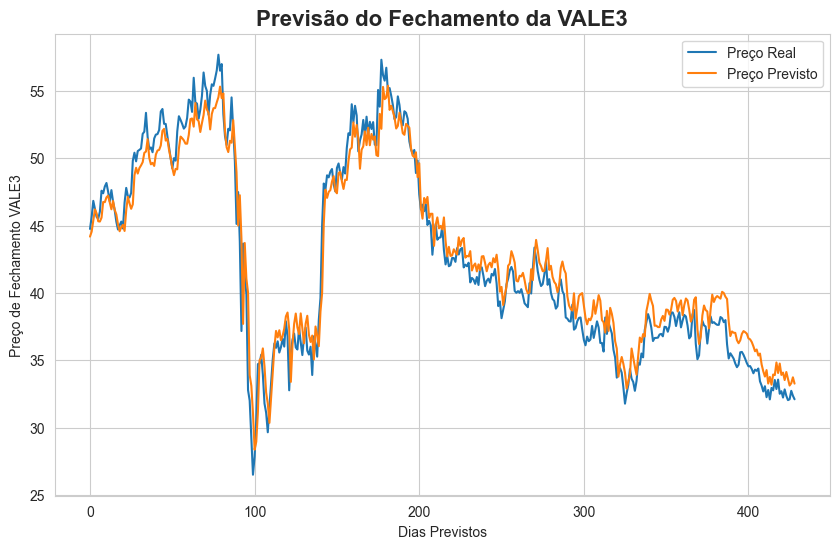

In [57]:
## 11. Gráfico

plt.figure(figsize = (10, 6))
sns.set_style('whitegrid')

plt.plot(y_real, label='Preço Real')
plt.plot(pred_real, label='Preço Previsto')

plt.xlabel('Dias Previstos')
plt.ylabel('Preço de Fechamento VALE3')
plt.title('Previsão do Fechamento da VALE3', fontweight='bold', fontsize=16)
plt.legend()

plt.show()

In [58]:
## 11. Tempo Final de Compilação

_end_time = time.time() - _start_time
print(f"Tempo total de execução: {_end_time:.2f} segundos")

Tempo total de execução: 34456.43 segundos
